## Speeding Up
- The part in QPE where we actually apply the phase kickback can be sped up using binary exponentiation over the Unitary matrix.
- When we are applying the matrix 2^(k-1) times to get a phase kickback, what we can do instead, is calculate the matrix 
    $$ U^{2^{k-1}}$$ using binary exponentiation and then use that as a **single** rotation gate instead of $$ O(2^{n}) $$ gates
- This would surely improve the circuit performance as it would improve circuit fidelity
- **NOTE** : this is just applicable when we want a simulation of our QPE algorithm and this is not representative of true phase estimation.
- This is because the classical computer would have to go inside the matrix representation of the unitary gate and if it can, it might as well determine the phase classically.

In [9]:
from qiskit import *
import matplotlib.pyplot as plt
from qiskit.extensions import UnitaryGate
from qiskit.circuit import add_control
from qiskit.tools.visualization import plot_bloch_multivector, plot_histogram
import numpy as np
from qiskit_textbook.tools import array_to_latex

In [10]:
from faster_basic_qpe import fast_QPE

## Making the Circuit
- The circuit is reduced to 4 unitaries instead of 15 
- The phase to be estimated is 0.2

In [11]:
U = np.array([[1, 0],
              [0, np.exp(2*np.pi*1j*(1/5))]])

Circuit for QFT of 4


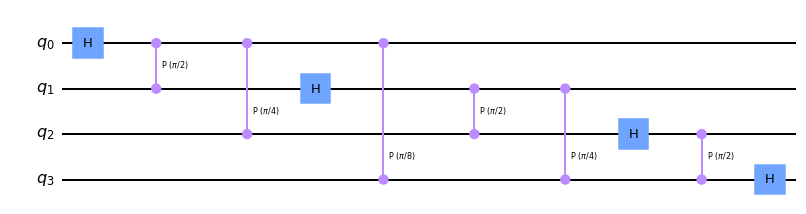

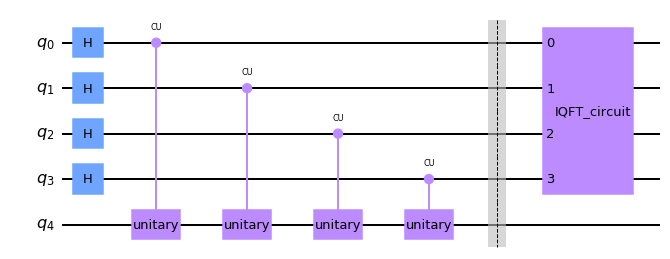

In [12]:
qpe_circ = fast_QPE(precision=4, unitary=U).get_QPE(show=True)

## Attaching the circuit

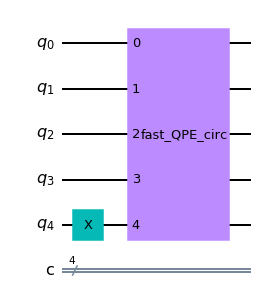

In [13]:
q = QuantumCircuit(5, 4)
q.x(4)
q.append(qpe_circ, qargs=[0, 1, 2, 3, 4])
# q = q.compose(qpe_circ,qubits = [0,1,2,3,4])
q.draw('mpl')

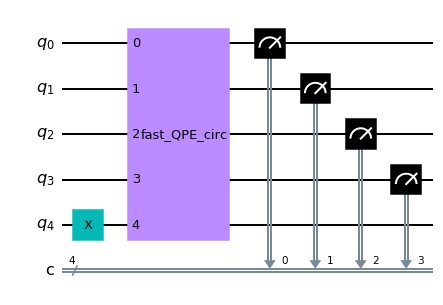

In [14]:
q.measure([0, 1, 2, 3], [0, 1, 2, 3])
q.draw('mpl')

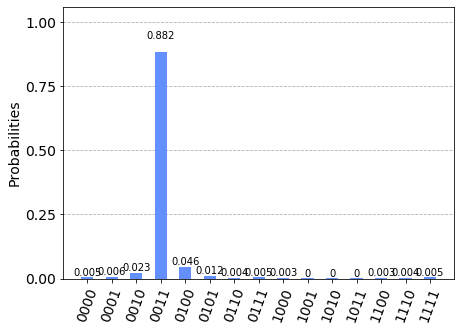

In [15]:
count = execute(q, backend=Aer.get_backend(
    'qasm_simulator')).result().get_counts()
plot_histogram(count)

- Yes! this is a correct circuit which actually used exponentially less gates to produce the same outputs

## Testing 3 qubit circuit
- Using a 2 qubit CP gate with $\theta = \frac {1}{7} $ is used to estimate the phase of the 2 qubit unitary
- Again, the phase is represented upto 4 bit precision as : 
$$\theta = 0.0010$$

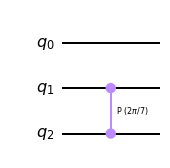

In [19]:
q = QuantumCircuit(3,name = 'Unitary')
q.cp(2*np.pi*(1/7),1,2)
display(q.draw('mpl'))
# u = execute(q,backend = Aer.get_backend('unitary_simulator')).result().get_unitary()

Circuit for QFT of 4


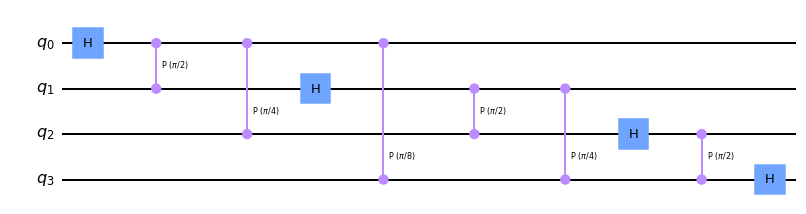

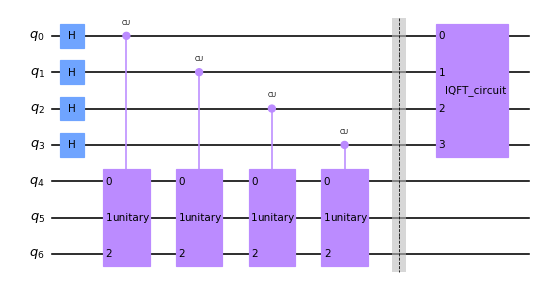

In [20]:
qpe_circ = fast_QPE(precision=4,unitary=q).get_QPE(show=True,save = True)

## Attaching the Circuit
- Using the eigenvector $|011 \rangle$ to generate the phase kickback in the Quantum Circuit

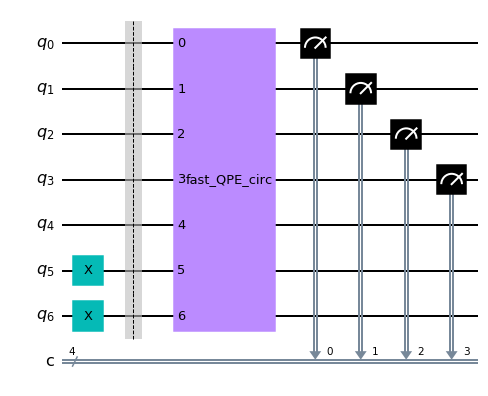

In [21]:
q = QuantumCircuit(7,4)
q.x([5,6])
q.barrier()
q.append(qpe_circ, qargs = [0,1,2,3,4,5,6])
q.measure([0,1,2,3],[0,1,2,3])
q.draw('mpl')

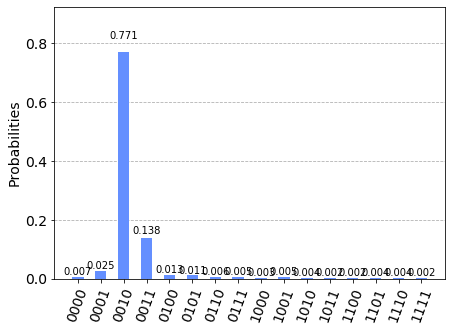

In [22]:
count = execute(q,backend=Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(count)

- Correct output pertaining to phase $\frac{1}{7}$ 

## Arbitrary Placement of Circuit

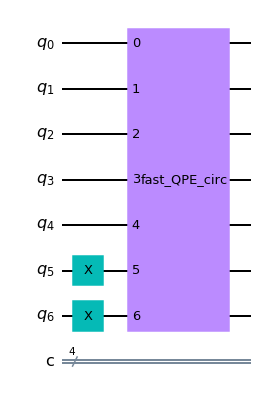

In [28]:
q = QuantumCircuit(7, 4)
q.x([5,6])
q.append(qpe_circ, qargs=range(7))
# q = q.compose(qpe_circ,qubits = [0,1,2,3,4])
q.draw('mpl')

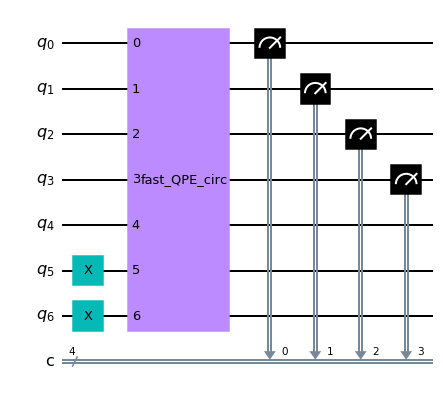

In [29]:
q.measure([0, 1, 2, 3], [0, 1, 2, 3])
q.draw('mpl')

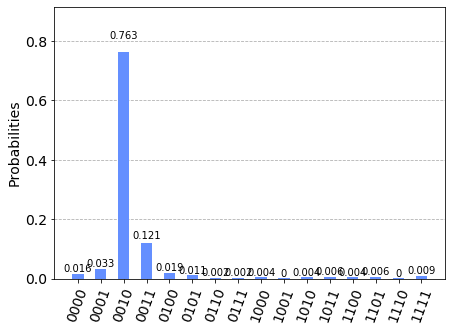

In [30]:
count = execute(q, backend=Aer.get_backend(
    'qasm_simulator')).result().get_counts()
plot_histogram(count)